<h2> Spectroscopic data reduction : spectra module

<h3> DIS demo

DIS notebook provides an opportunity to show how instruments with multiple 
channels might be handled. This notebook may not be as fully developed, 
e.g. as the KOSMOS notebook, but should provide some useful examples.

In [1]:
from pyvista import imred, tv, spectra
import numpy as np
import matplotlib.pyplot as plt
import os

pyvista uses a display tool defined in the tv module. To use the interactive
display in a notebook, set the display to be an external display window, e.g. with 
<code>
%matplotlib qt
</code>
Instantiate a tv object, here we just call it t, but you could call it whatever you want!

In [2]:
#Use these lines if you are running the notebook yourself. Matplotlib
# window will open outside the notebook, which is the desired behavior so
# you can have a single display tool, which you should leave open. Other
# plot windows will also appear outside the notebook, which you can close
# as desired
%matplotlib qt
t=tv.TV()
plotinter=True

# following lines only for fully non-interactive demo of notebook
#%matplotlib inline
#plotinter=False    # normally want this to be True!
#t=None


The basic tool for basic image reduction is a Reducer object, defined in the imred module. Instantiate a reducer here. The main argument is an instrument name, which tells it to read a YAML configuration file for the specified instrument. We also give it an optional dir= argument to specify the default directory from which to read images, if a directory is not specified in subsequent commands that read images.

In [3]:
red=imred.Reducer('DIS',dir='/home/holtz/red/UT191019/DIS')
red.dir='/home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS'

INSTRUMENT: DIS   config: 
  will use format:  /home/holtz/red/UT191019/DIS/*{:04d}b.f*.fits*
  will use format:  /home/holtz/red/UT191019/DIS/*{:04d}r.f*.fits*
         gain:  [1.68, 1.88]    rn: [ 4.9  4.6]
         scale:  None   
  Biastype : 0
  Bias box: 
    SC    NC    SR    NR
  2050    47     0  1024 
    SC    NC    SR    NR
  2050    47     0  1024 
  Trim box: 
    SC    NC    SR    NR
     0  2048     0  1024 
    SC    NC    SR    NR
     0  2048     0  1024 
  Norm box: 
    SC    NC    SR    NR
  1000    51   500   101 
    SC    NC    SR    NR
  1000    51   500   101 


A main method of the reducer object is the reduce() method. Without any additional arguments, reduce() will read an image from disk, subtract the overscan (region(s) as determined from the instrument configuration file), compute an uncertainty array using the gain and readout noise from the instrument configuration file, and return a CCDData object with the data, uncertainty, and mask. 
<p>
To specify the input image, we could pass a string with the file name. If the string does not include a '/', it will read from the default input directory.
<p>
If the file can be identified with a unique integer, then you can just specify this number, which can be very convenient. This is turned into a character string using the formstr attribute define in the configuration file, which is used to search for the file to read.
<p>
We can display the image using the tv() method of our display tool, which can take as input a Data object, and numpy array, or a FITS HDU object.

In [4]:
red.log().show_in_notebook(display_length=10)

idx,FILE,DATE-OBS,OBJNAME,RA,DEC,EXPTIME
0,He.0001b.fits,2019-10-19T00:21:15.084,,6:56:00.00,12:00:00.00,60.0
1,He.0001r.fits,2019-10-19T00:21:15.084,,6:56:00.00,12:00:00.00,60.0
2,Ne.0002b.fits,2019-10-19T00:23:01.758,,6:56:00.00,12:00:00.00,30.0
3,Ne.0002r.fits,2019-10-19T00:23:01.758,,6:56:00.00,12:00:00.00,30.0
4,Ar.0003b.fits,2019-10-19T00:24:18.389,,6:56:00.00,12:00:00.00,180.0
5,Ar.0003r.fits,2019-10-19T00:24:18.389,,6:56:00.00,12:00:00.00,180.0
6,BrQrtz.0004r.fits,2019-10-19T00:28:05.771,,6:56:00.00,12:00:00.00,120.0
7,BrQrtz.0004b.fits,2019-10-19T00:28:05.771,,6:56:00.00,12:00:00.00,120.0
8,BrQrtz.0005r.fits,2019-10-19T00:30:49.900,,6:56:00.00,12:00:00.00,120.0
9,BrQrtz.0005b.fits,2019-10-19T00:30:49.900,,6:56:00.00,12:00:00.00,120.0


Note that when we reduce an object, both channels are reduced, and
the output is returned as a list of two pyvista Data objects.

In [5]:
a=red.reduce(28)

if t is not None:
    t.tv(a[0])

  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/GB13.0028b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/GB13.0028r.fits
  subtracting overscan:  100.834
  subtracting overscan:  123.016
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


In [6]:
star=red.reduce(24)
if t is not None:
    t.tv(star[0])
    t.tv(star[1])

  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BD28d4211.0024b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BD28d4211.0024r.fits
  subtracting overscan:  100.721
  subtracting overscan:  121.353
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


<h4> Calibration: make and apply flat field

If we add additional arguments to reduce(), we can add additional calibration steps. For example, to flat field the data, we would add a flat= keyword through which we give the reducer a flat field. To add a spatial bias subtraction, we would add a bias= keyword through which we give the reducer a superbias frame.
<br>
First, however, we have to make the calibration products, which is accomplished using the mkflat(), mkbias(), etc methods. These take as input a list of frames to be used to construct the master calibration frame (e.g.. superflat). 

Create biases and flats. Note that for flats, we have to do scattered light removal, which can be done on reduction of individual images, but since it is slow, we will do it on the combined flat. If we add the display= keyword, giving a display object, then the calibration frames will be displayed, showing each input frame relative to the master frame, so you can inspect and make sure that bad frames are not being included in the combination.

In [7]:
vars(red)

{'dir': '/home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS',
 'root': '*',
 'verbose': True,
 'inst': 'DIS',
 'badpix': None,
 'scat': None,
 'bitmask': array([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], dtype=int16),
 'transpose': False,
 'scale': None,
 'biastype': 0,
 'channels': ['blue', 'red'],
 'gain': [1.68, 1.88],
 'rn': array([ 4.9,  4.6]),
 'saturation': [4294967296, 4294967296],
 'formstr': ['{:04d}b.f*', '{:04d}r.f*'],
 'cols': None,
 'ext': None,
 'crbox': [1, 11],
 'namp': 1,
 'biasavg': 11,
 'biasbox': [<pyvista.image.BOX at 0x2b0e9bcac3d0>,
 'biasregion': [<pyvista.image.BOX at 0x2b0e9bce0f70>,
 'trimbox': [<pyvista.image.BOX at 0x2b0e8b73fb50>,
 'outbox': [<pyvista.image.BOX at 0x2b0e8b73fb50>,
 'normbox': [<pyvista.image.BOX at 0x2b0e8b7479a0>,
 'nchip': 2}

In [8]:
flat=red.mkflat(range(4,12),spec=True,display=t)

  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0004b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0004r.fits
  subtracting overscan:  100.127
  subtracting overscan:  161.93
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0005b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0005r.fits
  subtracting overscan:  100.109
  subtracting overscan:  160.464
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0006b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0006r.fits
  subtracting overscan:  100.182
  subtracting overscan:  159.742
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0007b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BrQrtz.0007r.fits
  subtracting overscan:  100.078
  subtracting over

In [9]:
if t is not None :
    t.clear()
    t.tv(flat[0])
    t.tv(flat[1])

Note that the reduce() method will reduce both channels by default. If you are only interested in one, you can use the channel= keyword. But the calibration products that are supplied should be multi-channel in either case.

In [10]:
a=red.reduce(24,flat=flat,channel=1)

  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/BD28d4211.0024r.fits
  subtracting overscan:  121.353
  flat fielding...
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


Read and display a star spectral image. 

<h4> Tracing and extraction

In [11]:
btrace=spectra.Trace('DIS/DIS_blue_trace.fits')
rtrace=spectra.Trace('DIS/DIS_red_trace.fits')
vars(btrace)

no attribute:  index
no attribute:  index


{'type': 'Polynomial1D',
 'degree': 2,
 'sc0': 1049,
 'pix0': 0,
 'spectrum': array([ 0.27856965,  3.27856965,  0.27856965, ...,  0.        ,
         0.        ,  0.27856965]),
 'rad': 5,
 'lags': array([-300, -299, -298, -297, -296, -295, -294, -293, -292, -291, -290,
        -289, -288, -287, -286, -285, -284, -283, -282, -281, -280, -279,
        -278, -277, -276, -275, -274, -273, -272, -271, -270, -269, -268,
        -267, -266, -265, -264, -263, -262, -261, -260, -259, -258, -257,
        -256, -255, -254, -253, -252, -251, -250, -249, -248, -247, -246,
        -245, -244, -243, -242, -241, -240, -239, -238, -237, -236, -235,
        -234, -233, -232, -231, -230, -229, -228, -227, -226, -225, -224,
        -223, -222, -221, -220, -219, -218, -217, -216, -215, -214, -213,
        -212, -211, -210, -209, -208, -207, -206, -205, -204, -203, -202,
        -201, -200, -199, -198, -197, -196, -195, -194, -193, -192, -191,
        -190, -189, -188, -187, -186, -185, -184, -183, -182, -

In [12]:
btrace.trace(star[0],[663],plot=t)
rtrace.trace(star[1],[560],plot=t)

/home/holtz/git/pyvista/python/pyvista/spectra.py:1127: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) )[0]
/home/holtz/git/pyvista/python/pyvista/spectra.py:1138: RuntimeWarning: invalid value encountered in true_divide
  gd = np.where((~ymask) & (ysum/np.sqrt(yvar)>thresh) & (np.abs(res)<rad))[0]



  Tracing row: 560


<Figure size 432x288 with 0 Axes>

Sum up the arc lamp exposures, get the shift for the existing traces, and extract. Note that if you have a multiprocessor machine, you can specify number of threads to use for the extraction, which will speed things up (but the default threads=0 isn't too terrible).

In [13]:
arcs=red.sum([1,2,3])

  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/He.0001b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/He.0001r.fits
  subtracting overscan:  99.9985
  subtracting overscan:  120.003
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/Ne.0002b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/Ne.0002r.fits
  subtracting overscan:  99.9713
  subtracting overscan:  120.033
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/Ar.0003b.fits
  Reading file: /home/

In [14]:
bwav=spectra.WaveCal(file='DIS/DIS_blue_waves.fits')
rwav=spectra.WaveCal(file='DIS/DIS_red_waves.fits')

  rms:    0.233 Angstroms (5 lines)
  rms:    0.108 Angstroms (49 lines)


Do line identification based on previously identified lines, and wavelength fit.

  extracting ... 

  cross correlating with reference spectrum using lags:  range(-300, 300)
  Derived pixel shift from input wcal:  [ 0.00012173]
  See identified lines.
  rms:    0.102 Angstroms (5 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    0.102 Anstroms



1.8237479544871287

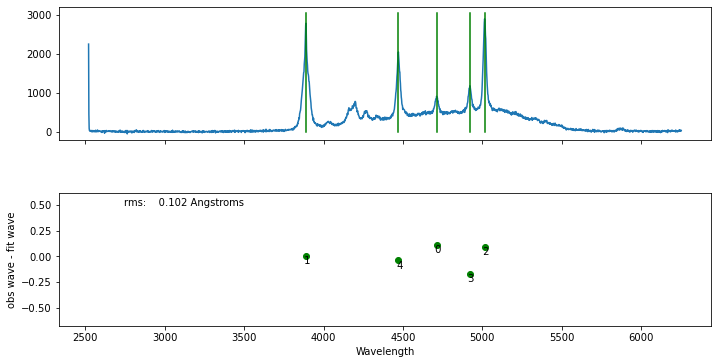

In [15]:
arcec=btrace.extract(arcs[0])
bwav.identify(arcec,plot=True,plotinter=plotinter,thresh=50) 
bwav.dispersion()

  extracting ... 

  rms:    0.108 Angstroms (49 lines)
  cross correlating with reference spectrum using lags:  range(-300, 300)
  Derived pixel shift from input wcal:  [ 0.00028472]
  See identified lines.
  rms:    0.100 Angstroms (33 lines)
  Input in plot window: 
       l : to remove all lines to left of cursor
       r : to remove all lines to right of cursor
       n : to remove line nearest cursor x position
       anything else : finish and return
  rms:    0.100 Anstroms



-2.3024957502684247

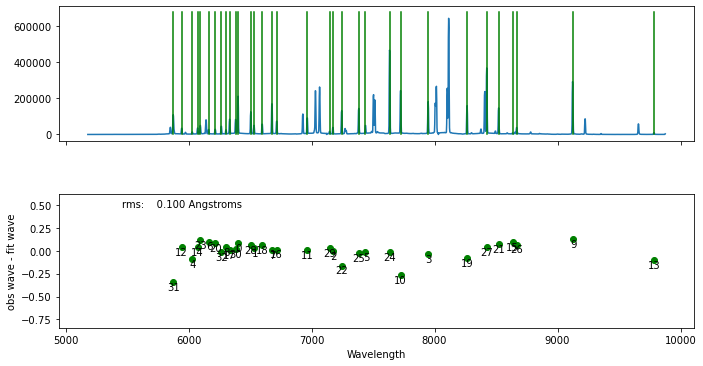

In [16]:
arcec=rtrace.extract(arcs[1])
rwav=spectra.WaveCal('DIS/DIS_red_waves.fits')
rwav.identify(arcec,plot=True,plotinter=plotinter,thresh=50) 
rwav.dispersion()

Now reduce an image

Get shift of traces, and extract. Alternatively, you could use a single call to retrace(), which will do the find() and then trace() using the shifted stored model as a starting guess.

In [17]:
im=red.reduce(27)

  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/GB13.0027b.fits
  Reading file: /home/astrobackup3/antares/holtz/raw/apo/oct19/UT191019/DIS/GB13.0027r.fits
  subtracting overscan:  100.94
  subtracting overscan:  122.585
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


In [18]:
btrace.find(im[0])
bimec=btrace.extract(im[0],display=t)
rtrace.find(im[1])
rimec=rtrace.extract(im[1],display=t)

  Derived pixel shift from input trace:  -116.688927403
  extracting ... 

  Derived pixel shift from input trace:  -122.836583446
  extracting ... 



Get the wavelengths for all pixels from the wavelength solution and plot extracted spectra.

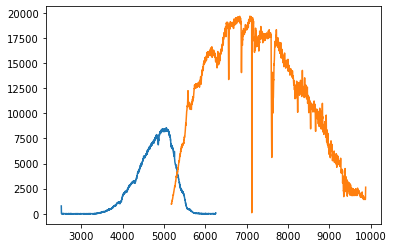

In [19]:
bwav.add_wave(bimec)
rwav.add_wave(rimec)
plt.figure()
for row in range(len(bimec.wave)) :
    plt.plot(bimec.wave[row],bimec.data[row])
for row in range(len(rimec.wave)) :
    plt.plot(rimec.wave[row],rimec.data[row])

Resample onto logarithmic wavelength grid and combine orders

/home/holtz/git/pyvista/python/pyvista/spectra.py:772: RuntimeWarning: invalid value encountered in true_divide
  out = out / sig
/home/holtz/git/pyvista/python/pyvista/spectra.py:773: RuntimeWarning: divide by zero encountered in true_divide
  sig = np.sqrt(1./sig)


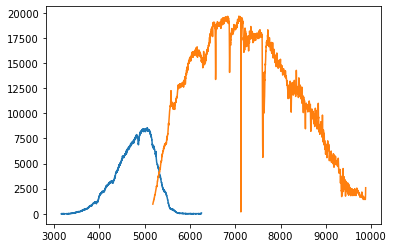

In [20]:
wnew=10**np.arange(3.5,4.0,5.5e-6)
bcomb=bwav.scomb(bimec,wnew,average=True,usemask=True)
rcomb=rwav.scomb(rimec,wnew,average=True,usemask=True)
plt.figure()
plt.plot(wnew,bcomb.data)
plt.plot(wnew,rcomb.data)

In [21]:
arc2d=btrace.extract2d(arcs[0])

  rms:    0.233 Angstroms (5 lines)
  cross correlating with reference spectrum using lags:  [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]
  Derived pixel shift from input wcal for row: 699 01


/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  See identified lines.
  rms:    1.723
rejecting 3 points from 350 total: 
  rms:    0.685
rejecting 2 points from 350 total: 
  rms:    0.685
rejecting 2 points from 350 total: 
  See 2D wavecal fit. Enter space in plot window to continue



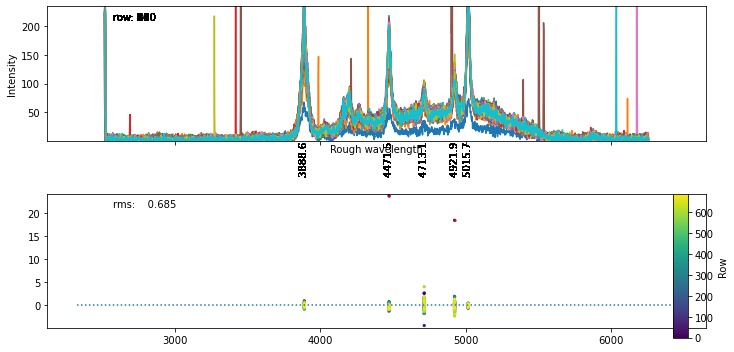

In [22]:
bwav=spectra.WaveCal('DIS/DIS_blue_waves.fits')
bwav.identify(arc2d,rad=10,nskip=10,lags=np.arange(-10,10),
              plot=True,plotinter=plotinter,thresh=10)

In [23]:
bwav.add_wave(arc2d)

In [24]:
dw=arc2d.wave-arc2d.wave[350]
if t is not None :
    t.tv(dw)

  rms:    0.108 Angstroms (49 lines)
  cross correlating with reference spectrum using lags:  [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9]
xcorr peak fit failed, row:  644  using peak
xcorr peak fit failed, row:  667  using peak
xcorr peak fit failed, row:  671  using peak
xcorr peak fit failed, row:  675  using peak
xcorr peak fit failed, row:  678  using peak
xcorr peak fit failed, row:  682  using peak
xcorr peak fit failed, row:  683  using peak
xcorr peak fit failed, row:  684  using peak
xcorr peak fit failed, row:  685  using peak
xcorr peak fit failed, row:  694  using peak
xcorr peak fit failed, row:  696  using peak
xcorr peak fit failed, row:  697  using peak
xcorr peak fit failed, row:  698  using peak
xcorr peak fit failed, row:  699  using peak
  Derived pixel shift from input wcal for row: 699 710


/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/local/Anaconda3-2020.02/envs/py3.9

  See identified lines.
  rms:   16.067
rejecting 1 points from 2238 total: 
  rms:    1.864
rejecting 1 points from 2238 total: 
  See 2D wavecal fit. Enter space in plot window to continue



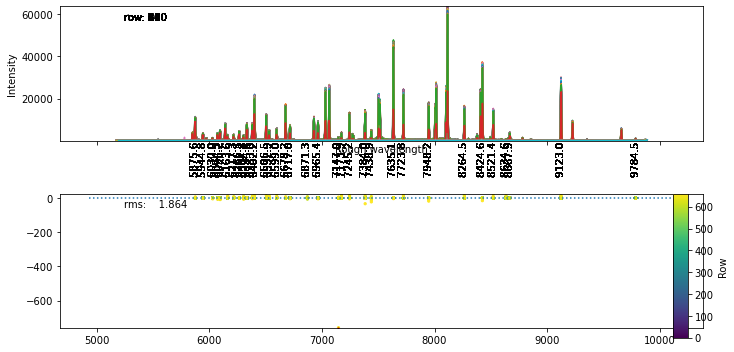

In [25]:
arcs2d=rtrace.extract2d(arcs[1])
rwav=spectra.WaveCal('DIS/DIS_red_waves.fits')
rwav.identify(arcs2d,rad=4,lags=np.arange(-10,10),nskip=10,
              plot=True,plotinter=plotinter,thresh=20)